# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/My Drive/Train_rev1.zip", index_col=None)
print(data.shape)
data

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,TEACHER OF SCIENCE,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244764,72705212,TEACHER OF BUSINESS STUDIES AND ICT,Position: Qualified Teacher or NQT Subject/Spe...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244765,72705213,ENGLISH TEACHER,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244766,72705216,SUPPLY TEACHERS,Position: Qualified Teacher Subject/Specialism...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

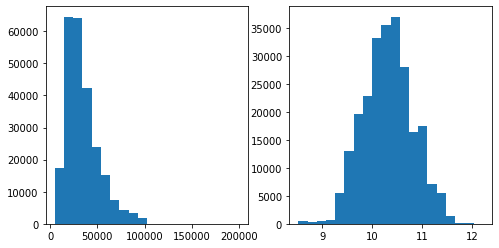

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
101140,69543980,CSCS Groundworkers,We are looking for experienced Groundworkers f...,Truro,Truro,full_time,NaN,Harbron Recruit Ltd,Trade & Construction Jobs,9.00 - 10.00 per hour,18240,Jobcentre Plus,9.811427
123757,69963110,Room Leader ****'s Teddington,Asquith is the UK s leading provider of premiu...,Teddington,Teddington,full_time,NaN,Asquith Day Nurseries,Teaching Jobs,18000 - 20000,19000,nurseryworldjobs.co.uk,9.852247
192064,71753316,Customer Service Advisor,We are currently looking for a part time custo...,Manchester,Manchester,full_time,NaN,Rullion Resource,Customer Services Jobs,6.50 - 6.50 per hour,12480,Jobcentre Plus,9.431963


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


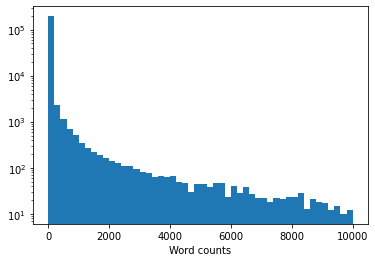

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [20]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
make_batch(data_train[:3], max_len=10)

{'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631]),
 'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [22]:
import torch
import torch.nn as nn
import torch.functional as F

In [23]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.hid_size = hid_size
        self.n_tokens = n_tokens
        self.n_cat_features = n_cat_features

        self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [24]:
model = SalaryPredictor()

In [25]:

model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [26]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [27]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 12
DEVICE = torch.device('cuda')

In [28]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [29]:

from IPython.display import clear_output
torch.manual_seed(42)

In [30]:
plt.style.use('seaborn-whitegrid')

In [31]:
def plotter(metrics, name):
  mses = [i[0] for i in list(metrics.values())]
  maes = [i[1] for i in list(metrics.values())]
  fig, ax = plt.subplots()
  ax.plot(mses, label = 'MSE')
  ax.plot(maes, label = 'MAE')
  ax.set_xticks(list(metrics.keys()))
  ax.legend()
  fig.suptitle(f'{name} val metrics')
  plt.show()
  

In [32]:
model = SalaryPredictor().cuda()
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, EPOCHS, batch_size, device, printf = True, name = ''):
  metrics = {}
  for epoch in range(EPOCHS):
      print(f"epoch: {epoch}")
      for i, batch in tqdm.notebook.tqdm(enumerate(
              iterate_minibatches(
                      data_train, 
                      batch_size=BATCH_SIZE, 
                      device=DEVICE)), 
                  total=len(data_train) // BATCH_SIZE
          ):
          model.train()
          pred = model(batch)
          optimizer.zero_grad()
          loss = criterion(pred, batch[TARGET_COLUMN])
          loss.backward()
          optimizer.step()

      clear_output()
      print(f'Epoch {epoch} train_loss', loss.item())
      metrics[epoch] = print_metrics(model, data_val, name='val', batch_size\
                                     =BATCH_SIZE, device=DEVICE)
      
      plotter(metrics, name)
      # display(metrics[epoch])
  clear_output()
  plotter(metrics, name)
  mdf = pd.DataFrame(index = list(metrics.keys()),
                     data = {'MSE': [i[0] for i in list(metrics.values())],
                             'MAE': [i[1] for i in list(metrics.values())]})
  if display:
    display(mdf)
  return metrics

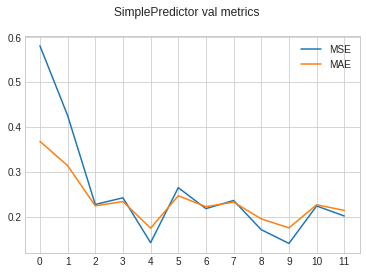

,MSE,MAE
0,0.581479,0.368282
1,0.426012,0.314066
2,0.227460,0.224455
3,0.242297,0.233906
4,0.142229,0.174537
5,0.264937,0.246836
6,0.218083,0.222433
7,0.236298,0.232682
8,0.171117,0.195214
9,0.140528,0.175191


In [ ]:
simple_model = train(model, EPOCHS ,BATCH_SIZE, DEVICE, name='SimplePredictor')

**1. Развейте СNN архитектуру (2 балла)**

Добавьте в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавьте раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано.

Как модель ведет себя в зависимости от количества обучаемых параметров?

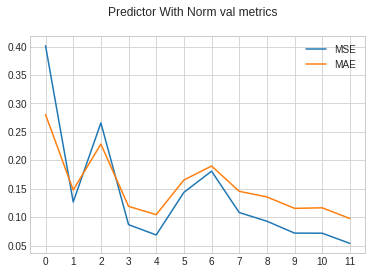

,MSE,MAE
0,0.401455,0.280529
1,0.126772,0.147704
2,0.265705,0.228546
3,0.086907,0.119023
4,0.068755,0.104526
5,0.143681,0.165372
6,0.180933,0.189987
7,0.108209,0.145520
8,0.092930,0.135629
9,0.072018,0.115554


In [ ]:
class SalaryPredictorWithNorming(SalaryPredictor):

    def __init__(self):
        super().__init__()

        self.title_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.hid_size, self.hid_size, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(self.n_cat_features, self.hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Linear(self.hid_size * 2, self.hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(self.hid_size * 4, self.hid_size),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1))
        


model = SalaryPredictorWithNorming().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
norm_model = train(model, EPOCHS, BATCH_SIZE, DEVICE, name = 'Predictor With Norm')

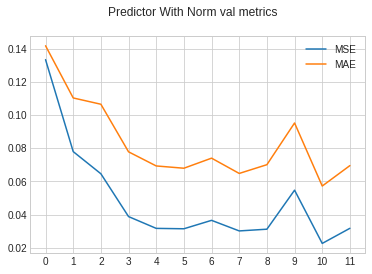

,MSE,MAE
0,0.133389,0.141772
1,0.077985,0.110315
2,0.064630,0.106527
3,0.038832,0.077852
4,0.031727,0.069344
5,0.031488,0.067971
6,0.036566,0.074037
7,0.030192,0.064829
8,0.031230,0.070106
9,0.054749,0.095237


In [ ]:
class SalaryPredictorWithParallelConvs(SalaryPredictor):

    def __init__(self):
        super().__init__()


        self.title_encoder_2 = nn.Sequential(
            nn.LazyConv1d(self.hid_size, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder_4 = nn.Sequential(
            nn.LazyConv1d(self.hid_size, kernel_size=(4, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1))

        self.description_encoder_2 = nn.Sequential(
            nn.LazyConv1d(self.hid_size, kernel_size=(2, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder_4 = nn.Sequential(
            nn.LazyConv1d(self.hid_size, kernel_size=(4, )),
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1))

        self.categorical_encoder = nn.Sequential(
            nn.LazyLinear(self.hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(self.hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(self.hid_size),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1))
        
    def forward(self, batch):

      title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
      title_features_2 = self.title_encoder(title_embeddings).squeeze()
      title_features_4 = self.title_encoder(title_embeddings).squeeze()
      title_features = torch.cat([title_features_2, title_features_4], dim=1)

      description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
      description_features_2 = self.description_encoder(description_embeddings).squeeze()
      description_features_4 = self.description_encoder(description_embeddings).squeeze()
      description_features = torch.cat([description_features_2, description_features_4], dim=1)

      categorical_features = self.categorical_encoder(batch['Categorical'])

      features = torch.cat(
          [title_features, description_features, categorical_features], dim=1)

      return self.final_predictor(features).squeeze()


model = SalaryPredictorWithParallelConvs().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
norm_model = train(model, EPOCHS, BATCH_SIZE, DEVICE, name = 'Predictor With Norm')

Объеденим многослойную модель с ранней остановкой

In [ ]:
def all_eq(a: 'list', Eps):
  deltas = []
  for i in range(1, len(a)):
    diff = a[i] - a[i - 1]
    deltas.append(diff)
  if len(set(a)) == 1:
    print('Loss differences of 3 epochs are equal. Stopping...')
    return False
  elif deltas[0] <= Eps and deltas[1] <= Eps:
    print('Loss differences after 3 epochs are smaller than {EPS}. Stopping...')
    return False
  elif a[2] > a[1] and a[1] > a[0]:
    print('Loss after 3 last epochs is on the rise. Stopping...')
    return False
  else:
    return True

def train_with_early_stopping(model, EPOCHS, batch_size, device, eps = 0.01, name = ''):
  metrics = {}
  err = []
  for epoch in range(EPOCHS):
      print(f"epoch: {epoch}")
      for i, batch in tqdm.notebook.tqdm(enumerate(
              iterate_minibatches(
                      data_train, 
                      batch_size=BATCH_SIZE, 
                      device=DEVICE)), 
                  total=len(data_train) // BATCH_SIZE
          ):
          model.train()
          pred = model(batch)
          optimizer.zero_grad()
          loss = criterion(pred, batch[TARGET_COLUMN])
          loss.backward()
          optimizer.step()

      clear_output()
      print(f'Epoch {epoch} train_loss', loss.item())
      
      metrics[epoch] = print_metrics(model, data_val, name='val', batch_size\
                                     =BATCH_SIZE, device=DEVICE)
      if epoch == 2:
        err = [i[0] for i in list(metrics.values())]
        if all_eq(err, Eps = eps):
          break
      elif epoch > 2:
        del err[0]
        err.append(metrics[epoch][0])
        if all_eq(err, Eps = eps):
          break
      plotter(metrics, name)
  # clear_output()
  plotter(metrics, name)
  mdf = pd.DataFrame(index = list(metrics.keys()),
                     data = {'MSE': [i[0] for i in list(metrics.values())],
                             'MAE': [i[1] for i in list(metrics.values())]})
  display(mdf)
  return metrics

Epoch 4 train_loss 0.11409129947423935
val results:
Mean square error: 0.79433
Mean absolute error: 0.43864


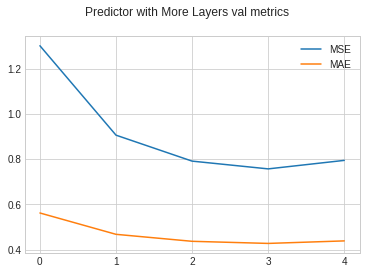

,MSE,MAE
0,1.300774,0.561953
1,0.905742,0.467650
2,0.791058,0.436822
3,0.756779,0.427500
4,0.794331,0.438644


In [ ]:
class DoNeuralNetsDreamOfMoreLayers(nn.Module):
    def __init__(self, 
                 n_tokens=len(tokens), 
                 n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 hid_size=8):
        super().__init__()
        self.hid_size = hid_size
        self.n_tokens = n_tokens
        self.n_cat_features = n_cat_features

        self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

model = DoNeuralNetsDreamOfMoreLayers().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
theydonot = train_with_early_stopping(model, EPOCHS, BATCH_SIZE, DEVICE, eps=0.001, 
                                   name = 'Predictor with More Layers')
  

**2. Pooling слои стандартные (1 балла)**

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

**Pooling** слои уменьшают размерность карты признаков, полученной в результате "сворачивания". Average Pooling усредняет полученную карту, Max Pooling выбирает максимальное значение из матрица признаков

Модифицируем исходную модель, добавив Max Pool слой после каждого сворачивания.

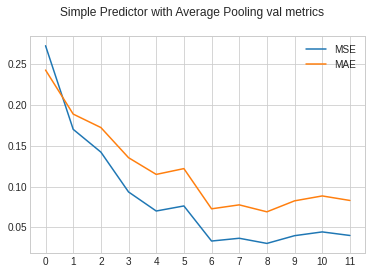

,MSE,MAE
0,0.272684,0.242883
1,0.170170,0.188864
2,0.142269,0.172384
3,0.093408,0.135411
4,0.070048,0.114927
5,0.076253,0.122045
6,0.033227,0.072734
7,0.036632,0.077586
8,0.030311,0.069055
9,0.039796,0.082514


In [39]:
class SalaryPredictorWithAveragePooling(SalaryPredictor):
  def __init__(self):
    super().__init__()

    self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
    self.title_encoder = nn.Sequential(
        nn.Conv1d(self.hid_size, self.hid_size, kernel_size=2),
        nn.AdaptiveAvgPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.description_encoder = nn.Sequential(
        nn.Conv1d(self.hid_size, self.hid_size, kernel_size=2),
        nn.AdaptiveAvgPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.categorical_encoder = nn.Sequential(
        nn.Linear(self.n_cat_features, self.hid_size * 2),
        nn.ReLU(),
        nn.Linear(self.hid_size * 2, self.hid_size * 2),
        nn.ReLU()
    )
    self.final_predictor = nn.Sequential(
        nn.Linear(self.hid_size * 4, self.hid_size),
        nn.ReLU(),
        nn.Linear(self.hid_size, 1)
        )
    
avg_pooling_model = SalaryPredictorWithAveragePooling().cuda()
optimizer = torch.optim.Adam(avg_pooling_model.parameters(), lr=0.001)
avg_pooling_metrics = train(avg_pooling_model, EPOCHS, BATCH_SIZE, DEVICE, name = 'Simple Predictor with Average Pooling') 

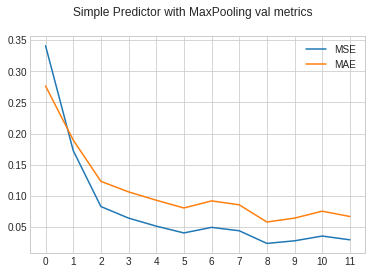

,MSE,MAE
0,0.341214,0.276535
1,0.172656,0.189603
2,0.082578,0.123173
3,0.063989,0.106161
4,0.051074,0.092773
5,0.040138,0.080285
6,0.049096,0.091678
7,0.043636,0.085394
8,0.023283,0.057698
9,0.027480,0.063987


In [ ]:
class SalaryPredictorWithMaxPooling(SalaryPredictor):
  def __init__(self):
    super().__init__()

    self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
    self.title_encoder = nn.Sequential(
        nn.Conv1d(self.hid_size, self.hid_size, kernel_size=2),
        nn.AdaptiveMaxPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.description_encoder = nn.Sequential(
        nn.Conv1d(self.hid_size, self.hid_size, kernel_size=2),
        nn.AdaptiveMaxPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.categorical_encoder = nn.Sequential(
        nn.Linear(self.n_cat_features, self.hid_size * 2),
        nn.ReLU(),
        nn.Linear(self.hid_size * 2, self.hid_size * 2),
        nn.ReLU()
    )
    self.final_predictor = nn.Sequential(
        nn.Linear(self.hid_size * 4, self.hid_size),
        nn.ReLU(),
        nn.Linear(self.hid_size, 1)
        )
    
max_pooling_model = SalaryPredictorWithMaxPooling().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
max_pooling_metrics = train(model, EPOCHS, BATCH_SIZE, DEVICE, name = 'Simple Predictor with MaxPooling')

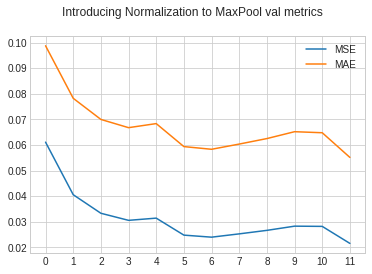

,MSE,MAE
0,0.061130,0.098770
1,0.040609,0.078254
2,0.033362,0.070001
3,0.030598,0.066784
4,0.031462,0.068374
5,0.024825,0.059394
6,0.024027,0.058343
7,0.025318,0.060381
8,0.026688,0.062527
9,0.028327,0.065209


In [40]:
class SalaryPredictorWithPoolingAndNormaliztion(SalaryPredictor):
  def __init__(self):
    super().__init__()

    self.embedder = nn.Embedding(self.n_tokens, self.hid_size)
    self.title_encoder = nn.Sequential(
        nn.Conv1d(self.hid_size, self.hid_size, kernel_size=2),
        nn.LazyBatchNorm1d(),
        nn.AdaptiveMaxPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.description_encoder = nn.Sequential(
        nn.Conv1d(self.hid_size, self.hid_size, kernel_size=2),
        nn.LazyBatchNorm1d(),
        nn.AdaptiveMaxPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.categorical_encoder = nn.Sequential(
        nn.Linear(self.n_cat_features, self.hid_size * 2),
        nn.ReLU(),
        nn.Linear(self.hid_size * 2, self.hid_size * 2),
        nn.ReLU()
    )
    self.final_predictor = nn.Sequential(
        nn.Linear(self.hid_size * 4, self.hid_size),
        nn.ReLU(),
        nn.Linear(self.hid_size, 1)
        )
    
model = SalaryPredictorWithPoolingAndNormaliztion().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_with_pooling_and_norm = train(model, EPOCHS, BATCH_SIZE, DEVICE, 
                                    name='Introducing Normalization to MaxPool')

**Результаты**  
  
Агрегируем результаты по моделям:

In [57]:
data_mse = [0.145931, 0.022664, 0.449076, 0.756779, 0.023283, 0.021589, 0.021122]
data_mae = [0.176511, 0.057244, 0.325678, 0.427500, 0.057698, 0.055161,0.054911]
res = {'MSE': data_mse, 'MAE': data_mae}
columns = ['Простая модель', "ПМ с нормализацией", "ПМ с параллельными conv слоями",
           "ПМ с ранней остановкой и дополниетельными слоями", "ПМ с max пулингом",
           "ПМ с average пулингом",
            "ПМ с нормализацией и max пулингом"]
results_conv_1 = pd.DataFrame(data = res, index = columns).sort_values('MSE')
results_conv_1

,MSE,MAE
ПМ с нормализацией и max пулингом,0.021122,0.054911
ПМ с average пулингом,0.021589,0.055161
ПМ с нормализацией,0.022664,0.057244
ПМ с max пулингом,0.023283,0.057698
Простая модель,0.145931,0.176511
ПМ с параллельными conv слоями,0.449076,0.325678
ПМ с ранней остановкой и дополниетельными слоями,0.756779,0.427500


Видно, что **модель с нормализацией и пулингом** имеет наибольшую предсказательную силу, так как имеет наименьший лосс (Р2 около 0.1). Модели с**усреднительным пулингом** и **максимизирующим пулингом и без нормализации** дают очень близкий результат, однако худший, нежели Max Pooling с нормализацией. Стоит учитывать, что в таблице представлены минимальные ошибки по любому индексу эпохи. В случае моедли **Norm + MaxPooling**, наиболее низкая ошибка получена с 11 эпохи.    
**Введение нормализации** также серьезно уменьшает MSE. Стакинг слоев увеличивает ошибку, возможно, влияет ранняя остановка, однако запуск модели (вне результатов в этом ноутбуке) свидетельствует о большой дисперсии значений ошибки. Стакинг слоёв в нашем случае оказывается сомнительной идеей. Параллельные слои проявили себя лучше стакинга слоев, но хуже стандартной модели и моделей с нормализацией и пулингом.

**3. Используйте предобученные эмбеддинги (2 балла)**

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

In [43]:
import gensim.downloader as api
embeds = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [45]:
class SalaryPredictorPretrainedEmbeddings(SalaryPredictor):
  def __init__(self, embeddings, freeze=True, **kwargs):
    super().__init__()

    self.embedder = nn.Embedding.from_pretrained(torch.Tensor(embeddings), 
                                                freeze=freeze)
    self.title_encoder = nn.Sequential(
        nn.LazyConv1d(self.hid_size, kernel_size=2),
        nn.LazyBatchNorm1d(),
        nn.AdaptiveMaxPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.description_encoder = nn.Sequential(
        nn.LazyConv1d(self.hid_size, kernel_size=2),
        nn.LazyBatchNorm1d(),
        nn.AdaptiveMaxPool1d(4),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.categorical_encoder = nn.Sequential(
        nn.LazyLinear(self.hid_size * 2),
        nn.ReLU(),
        nn.LazyLinear(self.hid_size * 2),
        nn.ReLU()
    )
    self.final_predictor = nn.Sequential(
        nn.LazyLinear(self.hid_size),
        nn.ReLU(),
        nn.LazyLinear(1))

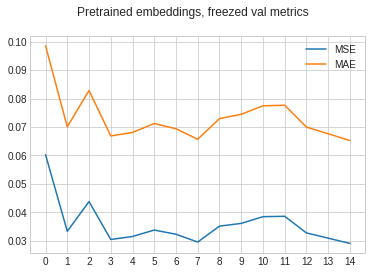

,MSE,MAE
0,0.060286,0.098512
1,0.033389,0.070047
2,0.043835,0.082818
3,0.030535,0.066861
4,0.031577,0.068084
5,0.033847,0.071226
6,0.032364,0.069378
7,0.029628,0.065697
8,0.035211,0.072923
9,0.036172,0.074465


In [ ]:
pretrained_freezed = SalaryPredictorPretrainedEmbeddings(embeds.vectors, freeze = True).cuda()
optimizer = torch.optim.Adam(pretrained_freezed.parameters(), lr=0.001)
pretrained_freezed_metrics = train(pretrained_freezed, EPOCHS, BATCH_SIZE, DEVICE, 
                                    name='Pretrained embeddings, freezed')

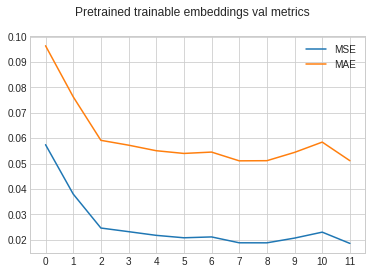

,MSE,MAE
0,0.057474,0.096436
1,0.038036,0.076329
2,0.024658,0.059192
3,0.023229,0.057286
4,0.021773,0.055103
5,0.020817,0.054029
6,0.021153,0.054563
7,0.018843,0.051116
8,0.018828,0.051173
9,0.020694,0.054444


In [46]:
pretrained_trainable = SalaryPredictorPretrainedEmbeddings(embeds.vectors, freeze = False).cuda()
optimizer = torch.optim.Adam(pretrained_trainable.parameters(), lr=0.001)
pretrained_trainable_metrics = train(pretrained_trainable, EPOCHS, BATCH_SIZE, DEVICE, 
                                    name='Pretrained trainable embeddings')

Модель с предобученными размороженными эмбеддингами Glove 50 Gigaword и нормализацией по батчу продемонстрировала наименьшую сумму квадратов остатков, поэтому сохраним модель для 5 задания. Кроме того, эта модель продемонстрировала самое быстрое схождение среди моделей своего класса: итоговое значение функции потерь на $\frac{3}{1000}$ ниже, чем у модели с нормировкой по батчам со случайно инициализируемыми эмбеддингами из гауссовского распределения и на $\frac{1}{1000}$ ниже, чем у модели с замороженными эмбеддингами.  
  
Отличия в моделях незначимы, так как сами модели, вероятнее всего, специфицированы некорректно. Некорректная спецификация модели, на пару с потенциаильной гетероскедастичностью и эндогенностью и нелинейностью по параметриам делают оценки наших моделей несостоятельными, неэффектинвными и смещенными. Нарушение предпосылок теоремы Гаусса-Маркова и приводят к категорически неприемлимым результатам моделирования. Коэффициент $R^2$ равен 0.1. (Оценивать нейросети простыми эконометрическими методы — сомнительная идея, но почему бы и нет))
  
Дабы убрать последние слои заменим их на Identity матрицу — функцию торча, пропускающую через себя данные без каких-либо манипуляций над ними.

In [71]:
from copy import deepcopy
forest = deepcopy(pretrained_trainable)
forest.final_predictor[1] = nn.Identity()
forest.final_predictor[2] = nn.Identity()
forest

SalaryPredictorPretrainedEmbeddings(
  (embedder): Embedding(400000, 50)
  (title_encoder): Sequential(
    (0): Conv1d(50, 8, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AdaptiveMaxPool1d(output_size=4)
    (3): Dropout(p=0.25, inplace=False)
    (4): ReLU()
    (5): AdaptiveMaxPool1d(output_size=1)
  )
  (description_encoder): Sequential(
    (0): Conv1d(50, 8, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AdaptiveMaxPool1d(output_size=4)
    (3): Dropout(p=0.25, inplace=False)
    (4): ReLU()
    (5): AdaptiveMaxPool1d(output_size=1)
  )
  (categorical_encoder): Sequential(
    (0): Linear(in_features=3768, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (final_predictor): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)


**4. Замените сверточные слои на рекуррентные (3 балла)**

* Замените сверточне слоим рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

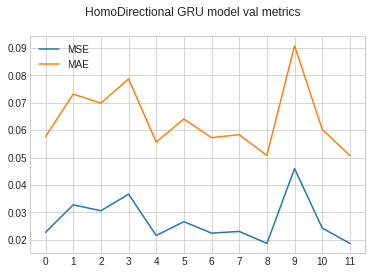

,MSE,MAE
0,0.022726,0.057643
1,0.032774,0.073208
2,0.030587,0.069875
3,0.036659,0.078743
4,0.021546,0.055663
5,0.026610,0.064124
6,0.022424,0.057297
7,0.023047,0.058368
8,0.018679,0.050795
9,0.045973,0.090848


In [ ]:
class GRU_SalaryPredictor(SalaryPredictor):
  def __init__(self, bidirectional=False, layers = 1):
        super().__init__()

        self.title_reccurent = nn.Sequential(
          nn.AdaptiveMaxPool1d(self.hid_size),
          nn.GRU(self.hid_size, self.hid_size, bidirectional=bidirectional,
                   num_layers = layers))
      
        self.description_reccurent = nn.Sequential(
            nn.AdaptiveMaxPool1d(self.hid_size),
            nn.GRU(self.hid_size, self.hid_size, bidirectional=bidirectional,
                   num_layers = layers))

        self.title_encoder = nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder = nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.categorical_encoder = nn.Sequential(
            nn.LazyLinear(self.hid_size * 4),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(self.hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(self.hid_size),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

  def forward(self, batch):

    title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
    title_features = self.title_reccurent(title_embeddings)[0]
    title_features = self.title_encoder(title_embeddings).squeeze()
    
    description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
    description_features = self.description_reccurent(description_embeddings)[0]
    description_features = self.description_encoder(description_embeddings).squeeze()

    categorical_features = self.categorical_encoder(batch['Categorical'])

    features = torch.cat(
        [title_features, description_features, categorical_features], dim=1)
    
    return self.final_predictor(features).squeeze()

EPOCHS = 12
gru_solo_mid = GRU_SalaryPredictor(bidirectional = False, layers= 1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
gru_solo_mid_metrics = train(model, EPOCHS, BATCH_SIZE, DEVICE, 
                                    name='HomoDirectional GRU model')

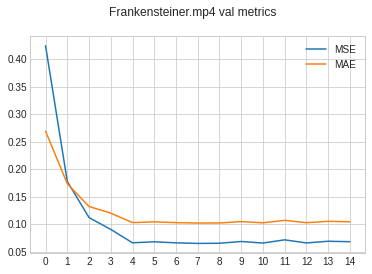

,MSE,MAE
0,0.424325,0.269223
1,0.177894,0.173696
2,0.112211,0.132356
3,0.090734,0.120245
4,0.066379,0.103092
5,0.068211,0.104440
6,0.066298,0.102984
7,0.065265,0.102229
8,0.065577,0.102425
9,0.068775,0.104825


In [ ]:
class GRU_Conv_SalaryPredictor(SalaryPredictor):
    def __init__(self, bidirectional=False, layers = 1):
        super().__init__()
        
        self.title_reccurent = nn.Sequential(
          nn.AdaptiveMaxPool1d(self.hid_size),
          nn.GRU(self.hid_size, self.hid_size, bidirectional=bidirectional,
                   num_layers = layers))
      
        self.description_reccurent = nn.Sequential(
            nn.AdaptiveMaxPool1d(self.hid_size),
            nn.GRU(self.hid_size, self.hid_size, bidirectional=bidirectional,
                   num_layers = layers))
        
        self.title_encoder = nn.Sequential(
            nn.LazyConv1d(self.hid_size, kernel_size=2),
            nn.LazyBatchNorm1d(),
            nn.AdaptiveMaxPool1d(4),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder = nn.Sequential(
            nn.LazyConv1d(self.hid_size, kernel_size=2),
            nn.LazyBatchNorm1d(),
            nn.AdaptiveMaxPool1d(4),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.categorical_encoder = nn.Sequential(
            nn.LazyLinear(self.hid_size * 4),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Linear(self.hid_size * 4, self.hid_size * 2),
            nn.LazyBatchNorm1d(),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(self.hid_size),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Linear(self.hid_size, 1)
        )

    def forward(self, batch):

        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_reccurent(title_embeddings)[0]
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_reccurent(description_embeddings)[0]
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        # display(features.shape)
        return self.final_predictor(features).squeeze(dim=0)

EPOCHS = 15
model = GRU_Conv_SalaryPredictor(bidirectional = True).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
Frankensteiner = train(model, EPOCHS, BATCH_SIZE, DEVICE, 
                                    name='Frankensteiner.mp4')

1. Однонаправленная GRU сетка (gru_solo_mid) демонстрирует лучшую производительность, нежели двунаправленная сетка (gru_double_mid)  
2. Фракенштейн модель продемоснтрировала неплохие результаты, однако ее лучший лосс в >3 раз выше Однонаправленной сетки.

Дополнительно оценим модель GRU модель, добавив в пайплайн предобученные эмбеддинги из предыдущего задания

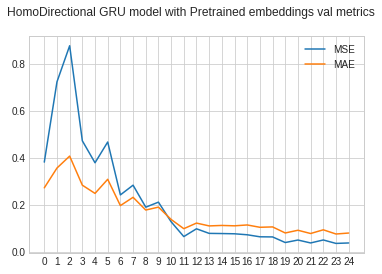

,MSE,MAE
0,0.382089,0.272522
1,0.724294,0.356890
2,0.878091,0.407762
3,0.472922,0.283798
4,0.379278,0.248753
5,0.467802,0.308951
6,0.242373,0.196757
7,0.283793,0.232159
8,0.190117,0.177865
9,0.211483,0.190268


In [ ]:
class GRU_SalaryPredictor_Pretrained(GRU_SalaryPredictor):
  def __init__(self, embds,  bidirectional=False, layers = 1, freeze = False):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(torch.Tensor(embds), 
                                                     freeze=freeze)

EPOCHS = 12
gru_homodir_model = GRU_SalaryPredictor_Pretrained(embds = embeds.vectors, 
                                   bidirectional = False, 
                                   layers= 1).cuda()
EPOCHS = 25
optimizer = torch.optim.Adam(gru_homodir_model.parameters(), lr=0.001)
gru_homodir_metrics = train(gru_homodir_model, EPOCHS, BATCH_SIZE, DEVICE, 
                                    name='HomoDirectional GRU model with Pretrained embeddings')

Результат GRU модели с предобученными эмбеддингами демонстрирет хороший результат: лосс всего на $\frac{2}{100}$ больше, нежели у сверточной модели с нормализацией

**5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)**

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли 
замена последнего слоя на ансамбль деревьев решений улучшить результат?

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error as mae, 
                             mean_squared_error as mse)

rf_regressor = RandomForestRegressor(warm_start = True, 
                                     n_estimators = 1000, 
                                     n_jobs=-1,)

In [90]:
def plotter_2(maes, mses):
  sns.set(style = 'whitegrid')
  fig, axes = plt.subplots(1, 2, figsize=(14, 5))
  sns.lineplot(data = mses, ax = axes[0])
  axes[0].set_title('Forest Model MSE')
  sns.lineplot(data = maes, ax = axes[1])
  axes[1].set_title('Forest Model MAE')
  fig.suptitle('RandomForest as last linear layers losses', y = 1.07)
  plt.tight_layout()
  plt.show()

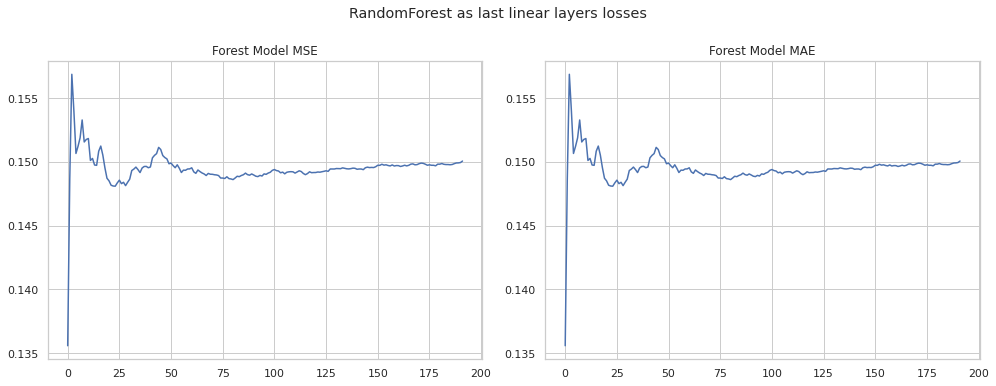

RF MSE: 0.13245754203073265 
RF MAE: 0.15005986841929633


In [91]:
# forest.cuda()
with torch.no_grad():

  mses = []
  maes = []

  mse_metrics = 0
  mae_metrics = 0
  
  num_samples = 0
  for batch in iterate_minibatches(data_val, batch_size=128, shuffle=False):
      batch = {x: y.cuda() for x, y in batch.items()}
      preds = forest(batch)
      preds_np = preds.detach().cpu().numpy()
      batch = {x: y.cpu().numpy() for x, y in batch.items()}
      rf_regressor.fit(preds_np, batch[TARGET_COLUMN])
      preds1 = rf_regressor.predict(preds_np)
      mse_metrics += mse(preds1, batch[TARGET_COLUMN])
      mae_metrics += mae(preds1, batch[TARGET_COLUMN])
      num_samples += len(batch)

      mse_rf = mse_metrics / num_samples
      mae_rf = mae_metrics / num_samples

      mses.append(mae_rf)
      maes.append(mae_rf)
      
      

plotter_2(maes, mses)
print(f'RF MSE: {mse_rf} \nRF MAE: {mae_rf}')

Замена последнего линейного слоя на ансамбль ~~ВИА~~ "Случайный лес" значимо увеличивает ошибку: с 0.018 до 0.13, что сопоставимо с простой моделью со случайными эмбеддингами и без нормализаций.

**6. Pooling слои *продвинутые* (3 балла)**

Реализуйте и примените
Softmax-pooling:$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

Attentive pooling$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$и $NN_{attn}$ полносвязный слой.


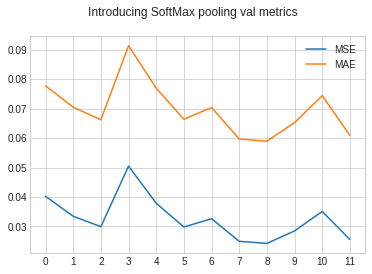

,MSE,MAE
0,0.040241,0.077735
1,0.033461,0.070506
2,0.029934,0.066208
3,0.050478,0.091351
4,0.037884,0.076946
5,0.029824,0.066406
6,0.032628,0.070381
7,0.024965,0.059671
8,0.024245,0.058955
9,0.028488,0.065255


In [ ]:
class SalaryPredictorSoftmaxPooling(SalaryPredictor):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()

        self.title_encoder = nn.Sequential(
            nn.LazyConv1d(hid_size, kernel_size=2),
            nn.Softmax(dim=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.LazyConv1d(hid_size, kernel_size=2),
            nn.Softmax(dim=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.LazyLinear(hid_size * 2),
            nn.ReLU(),
            nn.LazyLinear(hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear( hid_size),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
        #  YOUR CODE HERE

softmax_pooling_model = SalaryPredictorSoftmaxPooling().cuda()
optimizer = torch.optim.Adam(softmax_pooling_model.parameters(), lr=0.001)
softmax_pooling_metrics = train(softmax_pooling_model, EPOCHS, BATCH_SIZE, DEVICE, 
                                      name='Introducing SoftMax pooling')

In [ ]:
class AttentionPooling(nn.Module):
  '''Shamelessly taken from here: 
  https://github.com/winterant/Attentive-Pooling-Networks/blob/master/model.py'''

  def __init__(self, hidden_size, init_U='randn'):
      super().__init__()
      if init_U == 'zeros':
          self.U = nn.Parameter(torch.zeros(hidden_size, hidden_size))
      else:
          self.U = nn.Parameter(torch.randn(hidden_size, hidden_size))

  def forward(self, Q, A):
      G = Q.transpose(-1, -2) @ self.U.expand(Q.shape[0], -1, -1) @ A
      G = torch.tanh(G)
      Q_pooling = G.max(dim=-1)[0]
      A_pooling = G.max(dim=-2)[0]
      Q_pooling = Q_pooling.softmax(dim=-1)
      A_pooling = A_pooling.softmax(dim=-1)
      rq = Q @ Q_pooling.unsqueeze(-1)
      ra = A @ A_pooling.unsqueeze(-1)
      rq = rq.squeeze(-1)
      ra = ra.squeeze(-1)
      return rq, ra

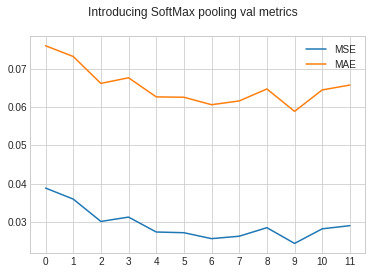

,MSE,MAE
0,0.038817,0.075970
1,0.035941,0.073167
2,0.030101,0.066138
3,0.031240,0.067607
4,0.027345,0.062624
5,0.027160,0.062524
6,0.025611,0.060575
7,0.026246,0.061561
8,0.028474,0.064690
9,0.024366,0.058841


In [ ]:
class SalaryPredictorWithAttentivePooling(SalaryPredictor):
  def __init__(self):
    super().__init__
    self.AttentionPooling = AttentionPooling(self.hid_size)
    self.title_encoder = nn.Sequential(
        nn.LazyConv1d(self.hid_size, kernel_size=2),
        nn.Softmax(dim=2),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.description_encoder = nn.Sequential(
        nn.LazyConv1d(self.hid_size, kernel_size=2),
        nn.Softmax(dim=2),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(output_size=1)
    )
    self.categorical_encoder = nn.Sequential(
        nn.LazyLinear(self.hid_size * 2),
        nn.ReLU(),
        nn.LazyLinear(self.hid_size * 2),
        nn.ReLU()
    )
    self.final_predictor = nn.Sequential(
        nn.LazyLinear(self.hid_size),
        nn.ReLU(),
        nn.LazyLinear(1)
        )
    def forward(self, batch):
      title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
      title_features = self.title_encoder(title_embeddings)

      description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
      description_features = self.description_encoder(description_embeddings)

      categorical_features = self.categorical_encoder(batch['Categorical'])

      col, row = self.attentive_pooling(title_features, description_features)
      features = torch.cat(
          [col.squeeze(), row.squeeze(), categorical_features], dim=1)

      return self.final_predictor(features).squeeze()

softmax_pooling_model = SalaryPredictorSoftmaxPooling().cuda()
optimizer = torch.optim.Adam(softmax_pooling_model.parameters(), lr=0.001)
softmax_pooling_metrics = train(softmax_pooling_model, EPOCHS, BATCH_SIZE, DEVICE, 
                                      name='Introducing SoftMax pooling')

In [94]:
data_mse = [0.145931, 0.068755, 0.449076, 0.756779, 0.023283, 0.021122, 0.024245, 
            0.027160,0.029150, 	0.018597, 0.018670, 0.049627, 0.065264, 0.132457,
            0.035611]
data_mae = [0.176511, 0.104526, 0.325678, 0.427500, 0.057698, 0.054911, 0.058955, 
            0.062524, 0.065255, 0.051165, 0.050736, 0.089845, 0.102228, 0.150059,
            0.075720]
res = {'MSE': data_mse, 'MAE': data_mae}
columns = ['Простая модель (ПМ)', "ПМ с нормализацией", "ПМ с параллельными conv слоями",
           "ПМ с ранней остановкой и дополнительными слоями", "ПМ с max пулингом",
            "ПМ с нормализацией и пулингом", "ПМ с софтмакс пулингом", "ПМ с пулингом внимания",
            "Замороженные эмбеддинги с нормализацией", "Обучаемые эмбеддинги с нормализацией", 
           "Однонаправленная GRU", "Двусторонняя GRU", "Франкенштейн (GRU + CV1d)", 
           "Случайный лес как линейный слой", "GRU с предобученными эмбеддингами без нормализации"]
results_conv_1 = pd.DataFrame(data = res, index = columns).sort_values('MSE')
results_conv_1

,MSE,MAE
Обучаемые эмбеддинги с нормализацией,0.018597,0.051165
Однонаправленная GRU,0.018670,0.050736
ПМ с нормализацией и пулингом,0.021122,0.054911
ПМ с max пулингом,0.023283,0.057698
ПМ с софтмакс пулингом,0.024245,0.058955
ПМ с пулингом внимания,0.027160,0.062524
Замороженные эмбеддинги с нормализацией,0.029150,0.065255
GRU с предобученными эмбеддингами без нормализации,0.035611,0.075720
Двусторонняя GRU,0.049627,0.089845
Франкенштейн (GRU + CV1d),0.065264,0.102228


Итак, в завершении лабы отметим следующее:  
Attentive и SoftMax пулинги значимо уменьшили лосс до 0.023, что сравнимо Max пулингом. 
В общем зачете побеждает модель с нормализацией и обучаемыми предварительно обученными эмбеддингами. Вслед за ней с минимальными отрывом в $\frac{73}{100000}$ однонаправленная GRU. Сверточная модель с нормализацией и max pooling_ом хуже на $\frac{3}{10000}$.  
  
Отметим также, что однонаправленная GRU модель продемонстрировала неплохой результат, однако в ее дизайне допущена ошибка — нет нормализации и пулингов. При добавлении нормализации и пулингов, по наивным оценкам, такая модель может обойти все остальные по предсказательной силе.